---
title: 'Lab03: Digit Recognition with Clustering'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: November 9, 2023
jupyter: python3
---

## Business Understanding

The data we are working with is part of the Modified National Institute of Standards and Technology (MNIST) digit recognition dataset for computer vision. The version we are using for this project is available from on [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview).

The MNIST dataset contains a large collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). This dataset is very commonly used in machine learning, and the objective is to correctly classify the digit in each image. Identifying handwritten digits is a common problem in many business use cases; a classifier could be used to automatically read addresses on envelopes, to read handwritten numbers on bank checks for mobile deposit, or to help grade tests in an educational setting.

For this project, we set out to explore the MNIST dataset using clustering techniques. Labels are available for this data, which makes it a good candidate for many other machine learning techniques. For example, the viability of Neural Networks for classifying digits has been well documented. In practice, labelling tens of thousands of handwritten digits may time and cost prohibitive. We believe that clustering has the potential to identify groups of similar digits, which could be more easily and efficiently labelled. This would allow generalization of handwriting recognition outside of digits, and even the English language. This would be especially useful in situations where labelling is cost prohibitive, or one just wants to do a rough grouping as part of the EDA on a fresh dataset. Labelling in this way could then serve as a preprocessing step for training more complex models. 

To evaluate our clustering analysis we will primarily use clustering metrics such as RAND, adj. RAND, inertia (SSE) and silhouette score to assess the performance of different clustering methods. We will then do a visual EDA or the digits in each cluster to assess whether it looks like the algorithm is working well. Finally, we will assess the accuracy in classifying digits after labelling the clusters. Although this is not necessarily a valid metric for assessing clustering performance, it provides useful validation for using this method on unlabelled data as a preprocessing step for supervised learning. Neural Networks regularly achieve accuracies of more than 99% on this dataset [@MNIST]. We do not expect to achieve this level of accuracy, but we do expect to be able to identify clusters of digits with similar characteristics. The clusters will also be visually evaluated for separation in order to judge the feasibility of using them as a preprocessing step for other machine learning techniques.

## Data Understanding 1


The MNIST data comes in two comma separated value files for the training and test data. Each row in the files contains the label for the digit, followed by 784 columns of pixel values. The pixel values are stored as integers between 0 and 255, which represent the grayscale value of the pixel. The training data contains 42,000 records, and the test data contains 28,000 records. The test data doesn't contain labels, and is used to evaluate model performance when submitted to Kaggle.

In [3]:
import pandas as pd

# Choose File
# RawTrain = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/train.csv"
# RawTest = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/test.csv"
RawTrain = "data/train.csv"
RawTest = "data/test.csv"

# Read the CSV file
train = pd.read_csv(RawTrain)
test = pd.read_csv(RawTest)

# Get info on the train dataset
print(train.info())

# Get info on the test dataset
print(test.info())

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The data appears to match the description.

### Verify Data Quality:

First we will check whether there is any missing values in the dataset. If so, we will visualize where they are and how we will address them.

In [4]:
# Check whether train or test have any missing values:
print(train.isnull().any().describe())
print(test.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


There are no missing values in the dataset.

In [3]:
# Not Needed:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Heatmap for training data
# plt.figure(figsize=(12, 6))
# sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Training Data')
# plt.show()

# # Heatmap for test data
# plt.figure(figsize=(12, 6))
# sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Test Data')
# plt.show()


Next we will check if there are any duplicated records in the datasets:

In [5]:
# Check for duplicate rows
duplicates = train[train.duplicated()]
print(duplicates.info())

duplicates = test[test.duplicated()]
print(duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 0.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 0.0 bytes
None


There are no duplicate rows in either dataset.

Next we will check for 'outliers'. Since the data is pixel values, we will check for values that are outside the range of 0 to 255. We will also check for unusual images by looking at the z-score of the sum of pixel values for each image. Since they are handwritten digits, we expect that the sum of pixel values will be similar for each image. Images outside of 3 standard deviations will be investigated further and may represent unusual images (e.g. images that are not digits, have colors reversed, etc.).

In [6]:
# Check whether any values are outside the range of 0 to 255:
print('Train records with value > 255:', train[train > 255].any().sum())
print('Train records with value < 0:', train[train < 0].any().sum())

print('Test records with value > 255:', test[test > 255].any().sum())
print('Test records with value < 0:', test[test < 0].any().sum())

Train records with value > 255: 0
Train records with value < 0: 0
Test records with value > 255: 0
Test records with value < 0: 0


There are no images with pixel values outside of the range of 0 to 255.

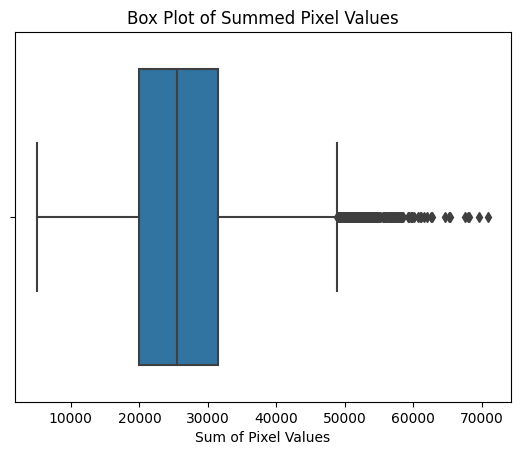

count      140.000000
mean     56014.321429
std       3808.971383
min      52092.000000
25%      53148.250000
50%      54790.000000
75%      57342.250000
max      70934.000000
dtype: float64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calculate Z-scores for the sum of pixel values:
pixel_sum = test.iloc[1:, :].sum(axis=1)
z_scores = stats.zscore(pixel_sum)
outliers = pixel_sum[(z_scores > 3) | (z_scores < -3)]

# Plot the distribution of pixel sums:
sns.boxplot(x=pixel_sum)
plt.title('Box Plot of Summed Pixel Values')
plt.xlabel('Sum of Pixel Values')
plt.show()

print(outliers.describe())

There are 140 records with a z-score greater than 3. We will view random images from this set to see if they are unusual:

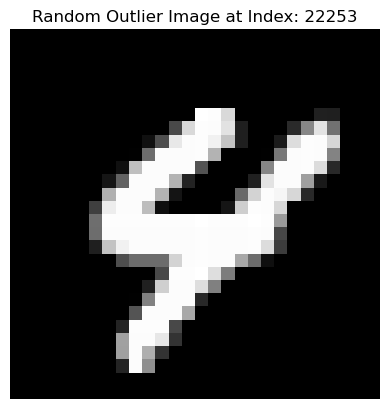

In [8]:
import matplotlib.pyplot as plt
import random

# Select a random index from the outliers
outlier_indexes = outliers.index
random_outlier_index = random.choice(outlier_indexes)

# Take the image data at the random index and reshape
image_data = train.iloc[random_outlier_index, 1:].values
image_matrix = image_data.reshape(28, 28)

# Display the image
plt.imshow(image_matrix, cmap='gray')
plt.title(f'Random Outlier Image at Index: {random_outlier_index}')
plt.axis('off')
plt.show()

The outliers all appear to be handwritten digits. There are some with especially broad strokes. Many appear to be digits with more complexity (8,3,5 for example). We will not remove these outliers.

## Data Understanding 2

To better understand the data, we will visualize some aspects. We will look at the distribution of digits within the training data. We will also view some of the images to see what they look like.

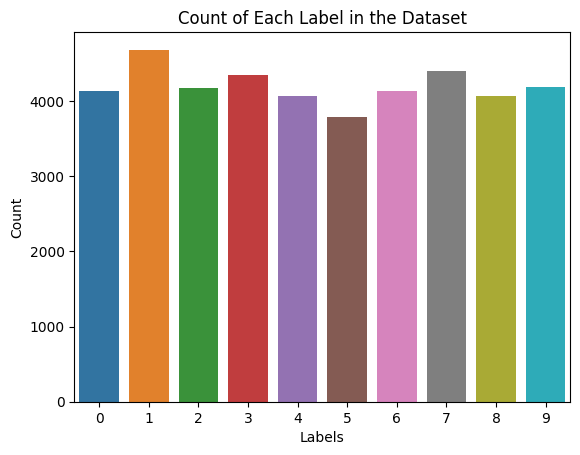

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot of digits
sns.countplot(x='label', data=train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label in the Dataset')

plt.show()


The digits in the training set appear uniformly distributed. Each label has approximately 4,000 samples or 10% of the dataset.

Here are some random images from the training set:

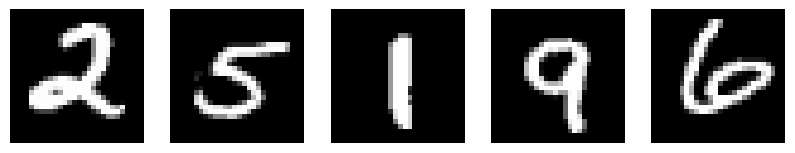

In [10]:
import numpy as np

# Display five random images from the training set:
def display_random_images(df, num_images):
    # Generate random indexes
    random_indexes = np.random.randint(0, len(df), num_images)

    # Retrieve random images by these indexes
    random_images = df.iloc[random_indexes, 1:].values

    # Reshape the random images to 28x28
    random_images = random_images.reshape(num_images, 28, 28)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        axes[i].imshow(random_images[i], cmap='gray')
        axes[i].axis('off')

    plt.show()
    
display_random_images(train, 5)

Above are five examples of what the images look like.

### Data Preparation

Next we will prepare the data for use in SciKit Learn. We will normalize the data by dividing each pixel value by 255, which will scale the values to between 0 and 1. We will also split the training set into training and validation subsets by using a Stratified Shuffle Split with 10% of the data used for validation.

In [11]:
from sklearn.model_selection import train_test_split

# Prepare the data for use in modelling:
y = train['label'].values
X = train.drop('label', axis=1).values
test_set = test.values

# Normalize the pixel data for both train and test:
X = X / 255.0
test_set = test_set / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.1, random_state=137, stratify=y)

## Modeling and Evaluation 1

Train and adjust parameters

The first thing we will do with the data is reduce the feature space using Principal Component Analysis (PCA). 784 features is fairly high. As shown below, we can explain most of the variance with just 100 principal components. Reducing the feature space will make clustering algorithms more efficient as it will reduce noise and help with the curse of dimensionality. The curse is that determining distance becomes more difficult in high-dimensional spaces because the distance between points becomes more similar as the number of dimensions increases. In addition to improving separation, reducing the feature space will also reduce the likelihood of overfitting, make some visualizations more possible, and require less processing power.

We will use the first 100 principal components in this analysis, which explains approximately 95% of the variance in the data.

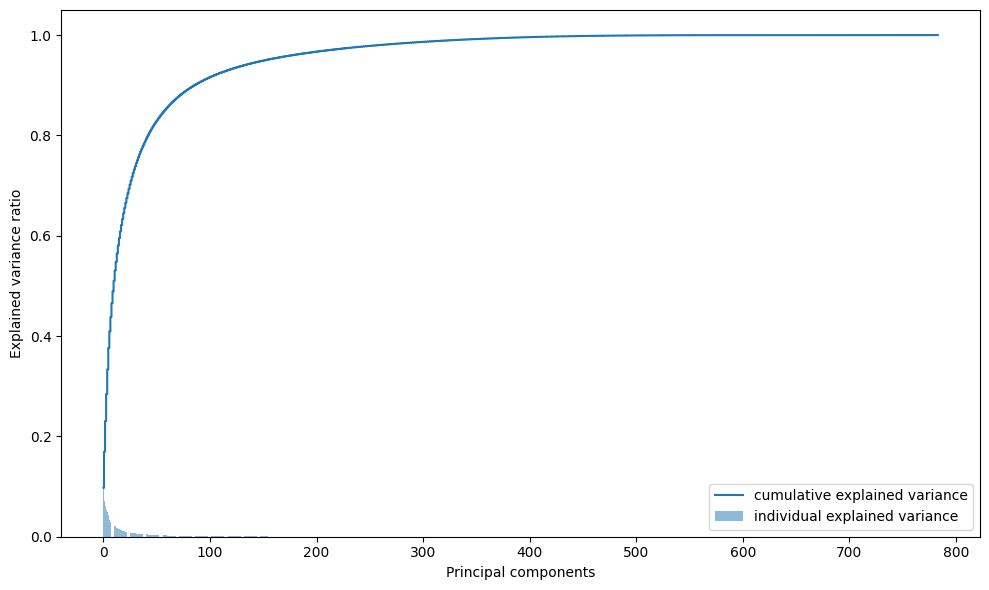

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### KMeans Model

KMeans is a clustering method that works by randomly initializing K centroids and then iteratively updating cluster assignments for the data to maximize seperation. It is best suited for data that forms roughly spherical clusters.

Scikit-Learn's implementation of KMeans has several parameters which can take on different values. We will use a grid search to find the best parameters for our data. Because silhouette score is not natively available to tune the grid search one and we have the labels for the training data, we will use the adjusted RAND score. In an implementation where labels are truly not available, silhouette score or another alternative would be a better choice and one could implement a custom scorer.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100
n_clusters = len(np.unique(y_train))

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('algorithm', KMeans(n_clusters=n_clusters, random_state=137, n_init='auto'))
])


Here we define a parameter grid to test different configurations of KMeans:

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'pca__n_components': [2, 10, 50, 100, 200],
    'algorithm__init': ['k-means++', 'random'],
    'algorithm__n_init': [1, 10, 20],
    'algorithm__max_iter': [50, 300, 500]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, 
                           scoring='adjusted_rand_score', 
                           cv=5, n_jobs=-1, verbose=0)


In [14]:
# Uncomment to run the grid search. Not necessary for notebook

# grid_search.fit(X_train, y_train)

In [15]:
# Uncomment to view the results of the grid search. Not necessary for notebook

# import pandas as pd

# # Extract the results from the grid search
# results = pd.DataFrame(grid_search.cv_results_)
# relevant_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
# filtered_results = results[relevant_columns]
# filtered_results = filtered_results.sort_values(by='mean_test_score', ascending=False)

# # Display the results
# pd.set_option('display.max_colwidth', None)
# print(filtered_results)

# print("Best parameters:", grid_search.best_params_)
# print("Best adjusted RAND score:", grid_search.best_score_)

There is a range of adjusted RAND scores for the parameters we have chosen. The best score is approximately 0.39, and the scores do not differ very much among the top performing configurations. In fact, the top configurations do not perform significantly differently than the default parameters for KMeans. Because this is the case, we will evaluate this algorithm on the defaults.

The grid search results do inform us on the the performance of PCA. It is clear that 2 components is not enough to achieve good clustering performance, but 50 components is on par with best results. This also suggests that since 50 components explains less variance than 100 or 200, that the algorithm is running into dimensionality issues. We will use 100 components for the remainder of the analysis.

In [16]:
# There are two options, best parameters or default settings
# Changing parameters doesn't seem to significantly change the results

# model = KMeans(init = 'random',
#                max_iter = 300,
#                n_init=1)
model = KMeans()

pipeline.set_params(pca = PCA(n_components = 100)),
pipeline.set_params(algorithm = model)

pipeline.fit(X_train)
kmeans_clusters = pipeline.predict(X_train)

kmeans_clusters

/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 6, 2, ..., 6, 2, 3], dtype=int32)

In the next step, we will assign the cluster the value of the mode of the labels for each cluster. This somewhat artificial step will allow us to evaluate the performance of the clustering algorithm by comparing the cluster labels to the true labels later in the analysis.

In the case where there are no labels, this step would be done by visualizing the images in each cluster and manually assigning a label based on domain knowledge. We will simulate this in the visualization step, but using the mode of the labels is a good approximation.

In [17]:
km_cluster_labels = np.zeros_like(kmeans_clusters)

for cluster in range(n_clusters):
    mask = (kmeans_clusters == cluster)
    if np.any(mask):
        km_cluster_labels[mask] = mode(y_train[mask])[0]
    else:
        print(f"Cluster {cluster} is empty.")


Cluster 8 is empty.
Cluster 9 is empty.


Although we assigned 10 clusters based on our knowledge of the data, the algorithm only finds eight distinct clusters. This likely means that there isn't enough separation between some of the digits using this algorithm. We will take this into account when selecting the best clustering algorithm.

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score
# Note RAND indices are semi-cheating. They require true labels

# Calculating the silhouette score
# Note: using `clusters` skips the label assignment (semi-supervised) step
km_silhouette = silhouette_score(X_train, kmeans_clusters)
print(f"Silhouette Score: {km_silhouette:.4f}")

# RAND score
km_rand = rand_score(y_train, kmeans_clusters)
print(f"RAND Index: {km_rand:.4f}")

# Adjusted RAND score
km_adjusted_rand = adjusted_rand_score(y_train, kmeans_clusters)
print(f"Adjusted RAND Index: {km_adjusted_rand:.4f}")


Silhouette Score: 0.0731
RAND Index: 0.8748
Adjusted RAND Index: 0.3962


The KMeans algorithm performs differently depending on which metric is used. Based on RAND score, the algorithm appears close to optimal, but when controlling for chance (adjusted RAND) it does less well. That said, all three metrics are on the positive side of their ranges which suggests that this algorithm is adding value.

### Spectral Clustering Model

Spectral Clustering is a method of dividing data into similar groups using graphs. The algorithm constructs a similarity matrix based on the distance between points, and then computes the eigenvectors of the matrix. The eigenvectors represent the data in a lower-dimensional space (spectral representation), and a traditional clustering method such as kmeans is used to find clusters from the spectral representation.

This method is effective in cases where clusters are not well represented by a spherical structure. It can capture non-linear relationships and is often used in image segmentation, and graph analysis of networks. Spectral clustering is computationally intensive because of the eigenvalue decomposition and therefore doesn't scale well to large datasets. We expect this method to perform better on the MNIST dataset, but will not spend too much time on hyperparameter tuning because of the computational cost and the fact that SKLearn's implementation of Spectral Clustering does not have a predict method.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from scipy.stats import mode

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100
n_clusters = len(np.unique(y_train))

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components, random_state=137)),
    ('algorithm', SpectralClustering(n_jobs=-1, random_state=137))
])


We will define the Spectral Clustering algorithm using the default parameters. The grid search option is not available for this algorithm because it isn't meant to be used for prediction. Nested for loops could be used to evaluate different parameters, but this would be computationally expensive. Empirically, we haven't seen much improvement in clustering performance when deviating from the default parameters. We are also primarily concerned with the differences between the algorithms, and not the absolute performance of each. For these reasons, we will use the default parameters for Spectral Clustering and acknowledge that more tuning is possible once the best algorithm is selected.

In [20]:
# Takes ~ 8 minutes to run with arpack. Takes ~ 15s with amg
spc = SpectralClustering(n_clusters=n_clusters,
                         eigen_solver='amg',         # default arpack. Other options: 'lobpcg', 'amg'
                         affinity='nearest_neighbors',  # default nearest_neighbors. Other options: 'rbf'
                         assign_labels='kmeans',        # default kmeans. Other options: 'discretize', 'cluster_qr'
                         n_init=10,                     # default 10, only used for kmeans
                         n_jobs=-1, random_state=137)
pipeline.set_params(algorithm = spc)

# pipeline.fit(X_train)
spec_clusters = pipeline.fit_predict(X_train)

spec_clusters

array([8, 7, 1, ..., 7, 2, 8], dtype=int32)

As with KMeans, we will simulate visually labelling the clusters by assigning each cluster the mode of the digits it contains.

In [21]:
spec_cluster_labels = np.zeros_like(spec_clusters)

for cluster in range(n_clusters):
    mask = (spec_clusters == cluster)
    if np.any(mask):
        spec_cluster_labels[mask] = mode(y_train[mask])[0]
    else:
        print(f"Cluster {cluster} is empty.")


We will evaluate the resulting clusters using the same metrics:

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score
# Note RAND indices are semi-cheating. They require true labels

# Calculating the silhouette score
# Note: using `clusters` skips the label assignment (semi-supervised) step
spec_silhouette = silhouette_score(X_train, spec_clusters)
print(f"Silhouette Score: {spec_silhouette:.4f}")

# RAND score
spec_rand = rand_score(y_train, spec_clusters)
print(f"RAND Index: {spec_rand:.4f}")

# Adjusted RAND score
spec_adjusted_rand = adjusted_rand_score(y_train, spec_clusters)
print(f"Adjusted RAND Index: {spec_adjusted_rand:.4f}")

Silhouette Score: 0.0235
RAND Index: 0.9240
Adjusted RAND Index: 0.6226


The Spectral Clustering algorithm has a similar Silhouette score to the KMeans model. The RAND score is slightly higher, and the adjusted RAND is much higher. This suggests that the MNIST data is not well represented by spherical clusters, which is in line with what we expected. For our use case, the adjusted RAND is probably the most important clustering metric.

### DBSCAN Model

DBSCAN is a density-based clustering scheme that does well with irregular and non-spherical clusters. I works by clustering points that are either in or within a certain distance of a high-density neighborhood of points. The algorithm designates all points not satisfying those criteria as noise.

The ability to discard noise points is advantageous in many types of image processing, but may be a disadvantage here because all the samples are legitimate. One could, however, imagine that the ability to identify outliers could be useful for unlabeled data. DBSCAN is subject to the curse of dimensionality and may not perform well with our high-dimensional data. It also is very sensitive to the epsilon and minimum points parameters and requires some tuning based on the data. Because we have a large dataset with a large number of dimensions and the algorithm is computing distances, DBSCAN can be computationally expensive for large values of either parameter.

We will explore whether DBSCAN can be used effectively with the MNIST dataset.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.stats import mode

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100
n_clusters = len(np.unique(y_train))

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components, random_state=137)),
    ('algorithm', DBSCAN(n_jobs=-1))
])


First we will try the DBSCAN algorithm with the default parameters.

In [24]:
dbs = DBSCAN(
    eps = 0.5,
    min_samples = 5,
    algorithm='auto',
    leaf_size=30,
    n_jobs=-1)
pipeline.set_params(algorithm = dbs)

# pipeline.fit(X_train)
dbs_clusters = pipeline.fit_predict(X_train)

dbs_clusters

array([-1, -1, -1, ..., -1, -1, -1])

With the default parameters, all of the samples are classified as noise and no clusters are found. We expected this based on the dimensionality of the data. The next step is to tune the epsilon and minimum points parameters for better clustering performance.

In Scikit-Learn, DBSCAN doesn't have a predict() method as it isn't meant to be used for assigning clusters to new points. One way to accomplish this is to use nested `for` loops to evaluate different combinations of parameters as shown below:

```{python}
from sklearn.metrics import adjusted_rand_score
import numpy as np

best_eps = 0.1
best_min_samples = 5
best_score = -1
best_num_clusters = 0

# Try different combinations of eps and min_samples
for eps in np.linspace(0.1, 1.0, 10):
    for min_samples in range(5, 50):
        dbs = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbs.fit_predict(X_train)

        # Check the number of clusters formed (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Check if cluster is useful before saving
        if n_clusters > 0 and not np.all(labels == -1):
            score = adjusted_rand_score(y_train, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_num_clusters = n_clusters

print(f"Best params - eps: {best_eps}, min_samples: {best_min_samples}, Score: {best_score}, Number of clusters: {best_num_clusters}")
```

This is extremely slow. SKL doesn't have a way to parallelize this, so the parameters are evaluated sequentially using a single thread in a single core. This loop would take about 10 hours to run, which is impractical. 

Instead, we will use the `dask` package to parallelize this task. Dask is a parallel and distributed computing library that can be used to scale computations in Python. It works by delaying the execution and building a compute graph. The graph is then analyzed and optimized before being executed in parallel. In our case, Dask will recognize that our computation can be run on as many cores as we can give it, and will distribute the work accordingly.

Here are the results:

In [32]:
# Can monitor progress at localhost:8787
# Large values of eps cause drastically increased space complexity

from dask.distributed import Client
from dask import delayed, compute
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Fit PCA to X_train:
pca = PCA(n_components=50, random_state=137)
X_pca = pca.fit_transform(X_train)

# Function to fit DBSCAN and compute the score
@delayed
def compute_dbscan_score(eps, min_samples):
    dbs = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1)
    labels = dbs.fit_predict(X_pca)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 0 and not np.all(labels == -1):
        score = adjusted_rand_score(y_train, labels) # Or silhouette_score()
        return eps, min_samples, score, n_clusters
    else:
        return eps, min_samples, -1, n_clusters

with Client(n_workers = 8, threads_per_worker =2) as client:
    # Prepare delayed tasks
    tasks = [compute_dbscan_score(eps, min_samples) 
            for eps in np.linspace(0.1, 5.0, 50) 
            for min_samples in range(2, 202, 10)]

    # Compute tasks in parallel
    results = compute(*tasks)

    # Find the best parameters
    best_result = max(results, key=lambda x: x[2])  # x[2] is the score

    best_eps = best_result[0]
    best_min_samples = best_result[1]
    print(f"Best params - eps: {best_result[0]}, min_samples: {best_result[1]}, Score: {best_result[2]}, Number of clusters: {best_result[3]}")
    # client.close()


/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Best params - eps: 4.2, min_samples: 92, Score: 0.10863760056404852, Number of clusters: 7


2023-11-25 11:34:11,416 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/distributed/worker.py", line 1255, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/distributed/utils_c

In [34]:
# results

After some significant hyperparameter tuning, the following results were found:

- Best Epsilon: 4.2
- Best Min Samples 92
- Best Adjusted Rand Score: 0.109

The results are not very good. The best score is only slightly better than random. It is possible that fine-tuning could improve the results, but the performance is not promising. It is likely that our data is too high-dimensional for DBSCAN to identify meaningful differences in density.

Next we will investigate the clusters we did identify:

In [35]:
from collections import Counter

# Fit DBSCAN with the best parameters
dbs = DBSCAN(eps=4.2, min_samples=92, n_jobs=-1)
dbs_clusters = dbs.fit_predict(X_train)

# Count the number of points in each cluster
cluster_counts = Counter(dbs_clusters)

for cluster, count in cluster_counts.items():
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    print(f"{label}: {count} samples")


Cluster 1: 391 samples
Noise: 33222 samples
Cluster 0: 4187 samples


DBSCAN has identified one normal size cluster, one very small one, and classified the rest of the samples as noise.

In [36]:
dbs_cluster_labels = np.zeros_like(dbs_clusters)

for cluster in range(n_clusters):
    mask = (dbs_clusters == cluster)
    if np.any(mask):
        dbs_cluster_labels[mask] = mode(y_train[mask])[0]
    else:
        print(f"Cluster {cluster} is empty.")


Cluster 2 is empty.
Cluster 3 is empty.
Cluster 4 is empty.
Cluster 5 is empty.
Cluster 6 is empty.
Cluster 7 is empty.
Cluster 8 is empty.
Cluster 9 is empty.


In [37]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score
# Note RAND indices are semi-cheating. They require true labels

# Calculating the silhouette score
# Note: using `clusters` skips the label assignment (semi-supervised) step
dbs_silhouette = silhouette_score(X_train, dbs_clusters)
print(f"Silhouette Score: {dbs_silhouette:.4f}")

# RAND score
dbs_rand = rand_score(y_train, dbs_clusters)
print(f"RAND Index: {dbs_rand:.4f}")

# Adjusted RAND score
dbs_adjusted_rand = adjusted_rand_score(y_train, dbs_clusters)
print(f"Adjusted RAND Index: {dbs_adjusted_rand:.4f}")

Silhouette Score: -0.0537
RAND Index: 0.3089
Adjusted RAND Index: 0.0503


Again the performance metrics are very poor. We conclude that DBSCAN is not appropriate for this type of clustering task and will not consider the algorithm for the remainder of the analysis.

## Modeling and Evaluation 2

Evaluate and Compare

To evaluate the clustering algorithms, we will use the silhouette score, RAND Index, and Adjusted RAND Index.

The silhouette score is the mean silhouette coefficient for all samples. The coefficient is measured by comparing the similarity (distance) of a sample to others in its cluster to that of the objects in the nearest cluster. It is a way to quantify how well-separated the clusters are, but may be misleading for high-dimensional data like the MNIST dataset is even after PCA. The metric also assumes the clusters are uniform and convex, which we have seen is not the case for the MNIST data.

The RAND Index is a measure of similarity between two data clusterings. It compares the number of pairs of samples that are assigned to the same or different clusters. In our case, we are comparing the clustering algorithms to the true labels. Adjusted RAND takes into account chance pairings and is a more rigorous metric than the RAND Index. Both indices range from -1 to 1. A score of 1 indicates perfect agreement between the two clusterings, a score of 0 indicates random chance.

Although we are evaluating the clustering algorithms for a use case where labels aren't available, it makes sense to use the labels from the MNIST dataset to compare how the methods have performed. This would be the primary metric of concern to someone using these algorithms to generate labels as a preprocessing step for supervised learning, so we will focus on the Adjusted RAND Index.

In [38]:
import numpy as np
import pandas as pd

data = {
    "Silhouette Score": [km_silhouette, spec_silhouette, dbs_silhouette],
    "RAND Index": [km_rand, spec_rand, dbs_rand],
    "Adjusted RAND Index": [km_adjusted_rand, spec_adjusted_rand, dbs_adjusted_rand]
}

df = pd.DataFrame(data, index=["KMeans", "Spectral Clustering", "DBSCAN"])

# Function to highlight the maximum in each column - GPT-4
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

styled_df = df.style.apply(highlight_max, props='color:red;', axis=0)
styled_df


,Silhouette Score,RAND Index,Adjusted RAND Index
KMeans,0.073128,0.874850,0.396210
Spectral Clustering,0.023513,0.924008,0.622572
DBSCAN,-0.053658,0.308915,0.050319


Based on the Adjusted RAND Index, the Spectral Clustering algorithm performs the best. This makes sense, since the digits are image data and are not likely to be represented well by spherical clusters.

As discussed, using classification is better accomplished with supervised learning methods. However, since our use case involves using clustering to help generate labels for unlabeled data, it makes sense to look at accuracy to learn more about how the algorithms perform.

Our best performing clustering algorithm, Spectral Clustering, does not have the ability to make predictions on data outside the test set. We will instead define a K-Nearest Neighbors classifier using the training data and the cluster labels and use that to assign the test data to clusters. This calculation is done below using 50 nearest neighbors.

In [24]:
# Test set accuracy of KNN prediction on Spectral Clusters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, spec_clusters)

predicted_clusters = knn.predict(X_test)

cluster_to_label_map = {}

for cluster in range(n_clusters):
    mask = (spec_clusters == cluster)
    if np.any(mask):
        # Map spectral cluster ID to its corresponding label
        cluster_to_label_map[cluster] = mode(y_train[mask])[0]

# Convert predicted cluster IDs to labels
predicted_labels = np.array([cluster_to_label_map[cluster_id] for cluster_id in predicted_clusters])

knn_spectral_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test set Accuracy: {knn_spectral_accuracy:.4f}")

Test set Accuracy: 0.7321


Assigning the test data labels in this way results in an accuracy of 0.73. That is an admirable performance considering that the algorithm was unsupervised and the labels were generated post-hoc.

In our proposed use case, this means that the labeler could start with clusters of images that are 73% correct and realize a significant time savings over manually labeling each image. Naively, this would result in approximately a 400% increase in efficiency. This is a very rough estimate, but it does suggest that this method could be useful in practice.

To learn more about the algorithm's performance we will also look at per class accuracy:

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
print(cm)

# Accuracy per class
class_accuracies_test = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_test):
    print(f"Accuracy for class {i}: {accuracy:.4f}")


[[404   0   0   3   1   0   1   0   4   0]
 [  0 466   1   0   0   0   0   1   0   0]
 [  4  15 377   0   2   0   1  14   5   0]
 [  1   2   2 416   1   0   0   6   7   0]
 [  2   5   0   0 397   0   0   2   1   0]
 [  0   3   0 166   7   0   8   0 196   0]
 [  3   0   0   1   2   0 394   0  14   0]
 [  0  12   0   1  17   0   0 410   0   0]
 [  0  10   0 173  10   0   1   1 211   0]
 [  5   3   0  10 338   0   0  13  50   0]]
Accuracy for class 0: 0.9782
Accuracy for class 1: 0.9957
Accuracy for class 2: 0.9019
Accuracy for class 3: 0.9563
Accuracy for class 4: 0.9754
Accuracy for class 5: 0.0000
Accuracy for class 6: 0.9517
Accuracy for class 7: 0.9318
Accuracy for class 8: 0.5197
Accuracy for class 9: 0.0000


These results suggest that some digits have a very large degree of separation and the algorithm does quite well at grouping them together. The class accuracies for '0', '1', '3', '4', and '6' are all above 95%. The algorithm does have difficulty with '5', '8', and '9', in fact failing to label any cluster as '5' or '9'.

Knowing these weak points could allow labelling efforts to be targeted toward the most difficult digits, saving further time and increasing accuracy.

## Modeling and Evaluation 3

Visualize Results

Now we will visualize the clusters to see how well they separate the digits. We will take a random sample of images from each cluster and compare to the label assigned by the algorithm. In our proposed use case, the labeller would look at the random samplings at this stage and manually assign a label. From this visualization, we will be able to see how well the digits are separated and which the algorithm struggles with.

We will also visualize a plot of the first two principal components by cluster. These two components capture a large portion of the variance and will allow us to visualize the clusters in lower-dimensional space. Knowing that the digits are approximately uniformly distributed, we would expect to see similar sizes of clusters.

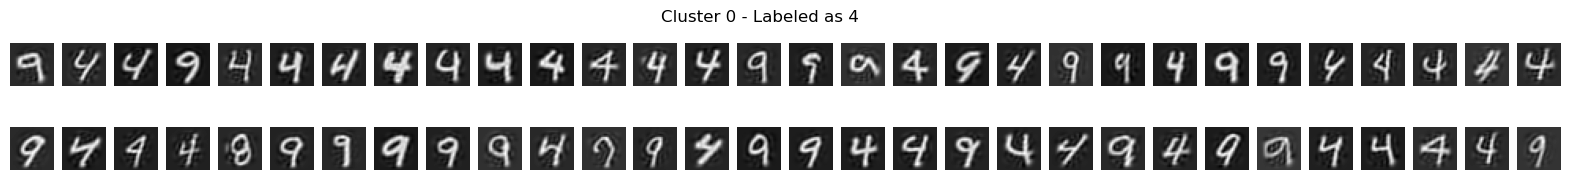

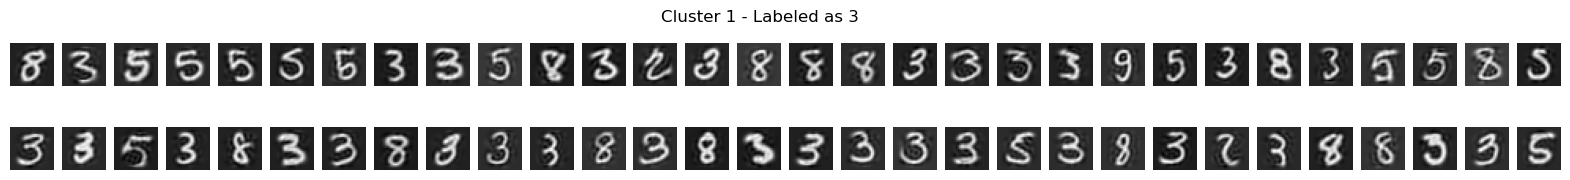

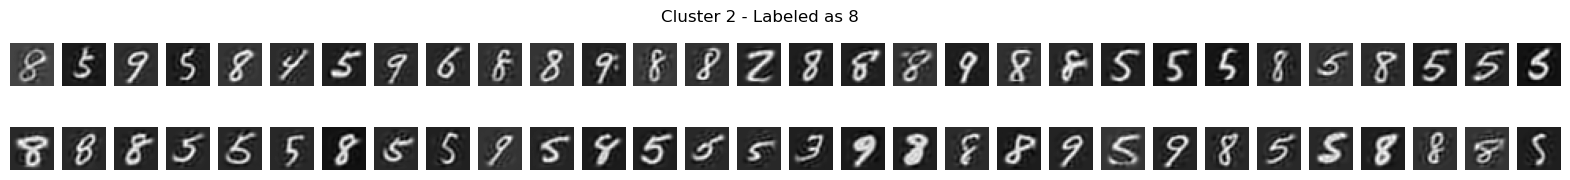

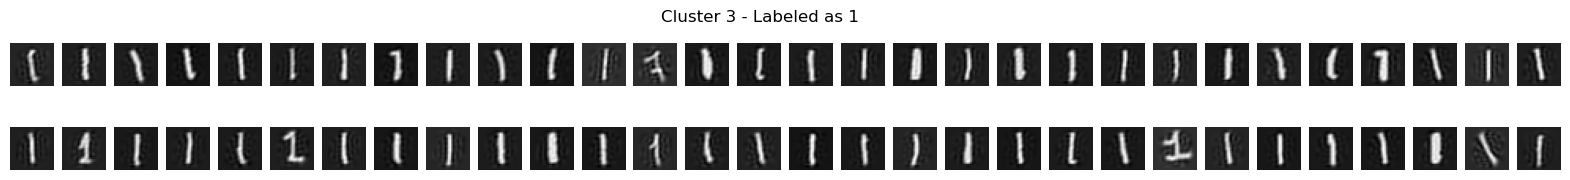

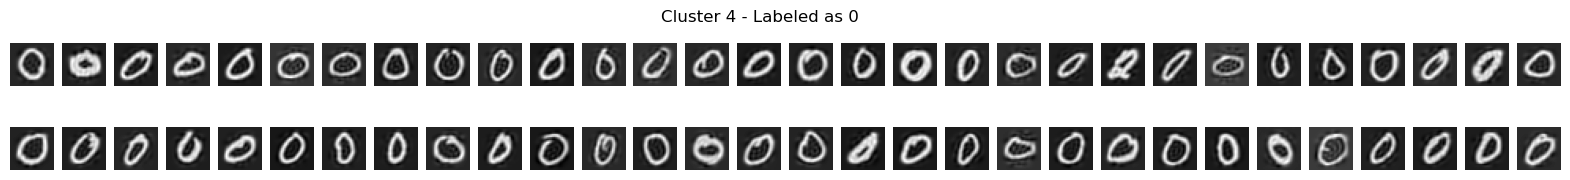

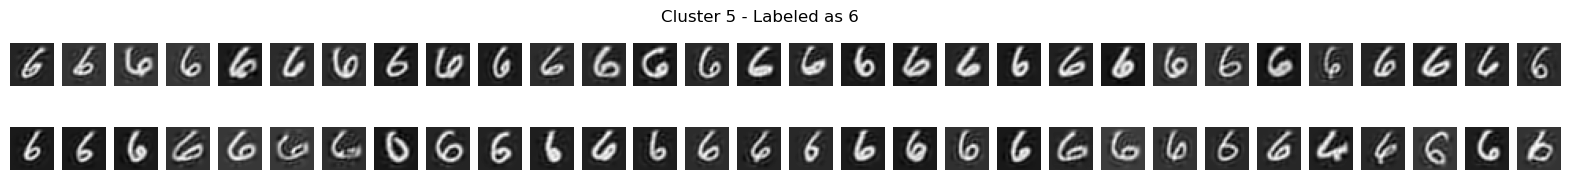

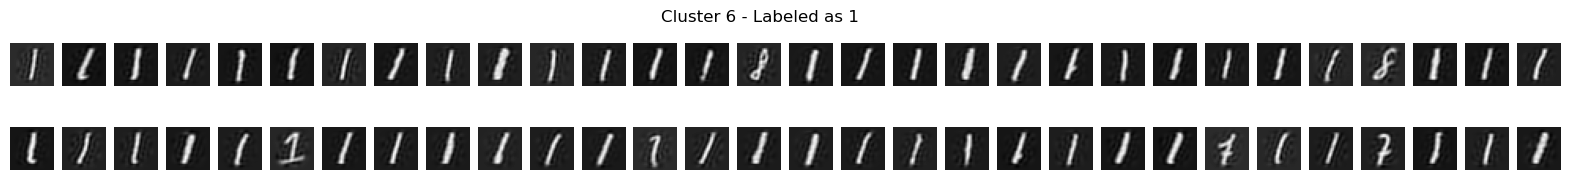

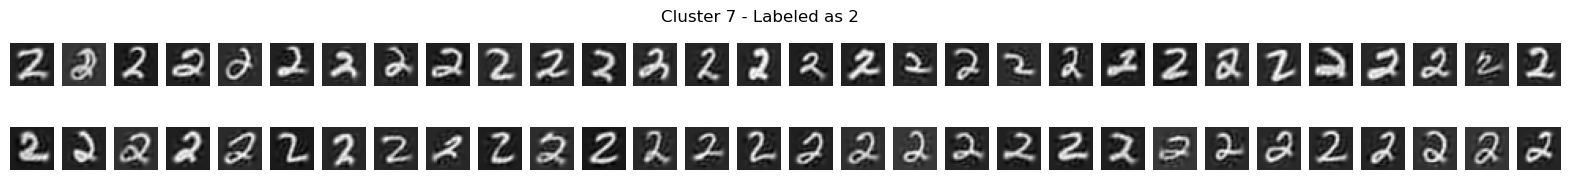

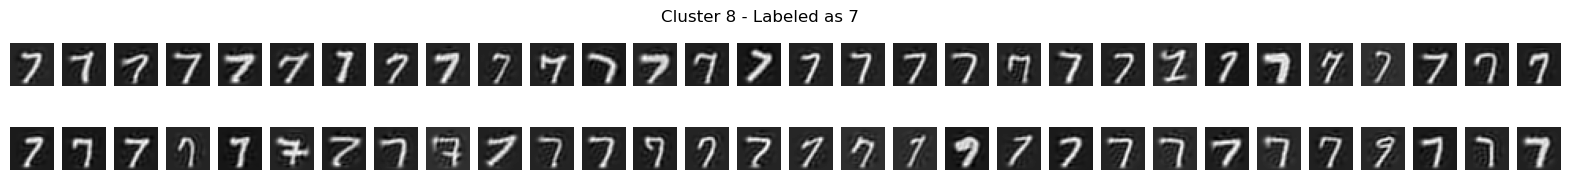

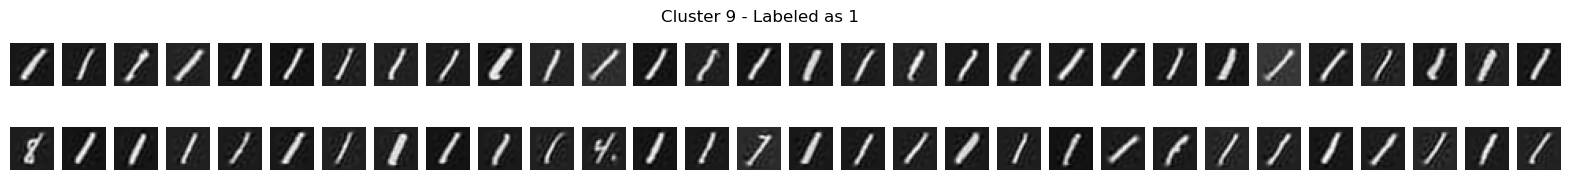

In [26]:
import matplotlib.pyplot as plt
import random

# Number of images per cluster to display
num_images = 60
num_rows = 2
num_cols = num_images // num_rows

# Access the PCA component from the pipeline
pca = pipeline.named_steps['pca']

for cluster in range(n_clusters):
    # Find indexes of images in this cluster
    indexes = np.where(spec_clusters == cluster)[0]

    # Randomly select indexes
    selected_indexes = random.sample(list(indexes), min(len(indexes), num_images))

    # Plotting
    plt.figure(figsize=(20, 2))
    for i, index in enumerate(selected_indexes):
        # Retrieve the PCA-transformed data for the selected index
        pca_transformed_data = pca.transform(X_train[[index]])

        # Inverse transform to reconstruct the image
        reconstructed_image = pca.inverse_transform(pca_transformed_data)
        image_matrix = reconstructed_image.reshape(28, 28)  # Reshape

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_matrix, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Cluster {cluster} - Labeled as {spec_cluster_labels[indexes[0]]}')
    plt.show()


Most of the clusters appear to be well separated. The algorithm does struggle to classify between '3' and '8', '4' and '9', and '7' and '9'. As noted earlier, there are no clusters that have enough '5's or '9's to be labelled as such, so those digits tend to be mixed in with other clusters. Our algorithm appears to do extremely well with '1's, '2's, '6's, and '0's.

Based on a visual inspection, we expect that this algorithm would be extremely useful for a labeller tasked with assigning labels to handwritten digits. The labeller could quickly assign labels to the clusters that are well separated, do a cursory review of them and then spend more time on the clusters that are more difficult to separate. 

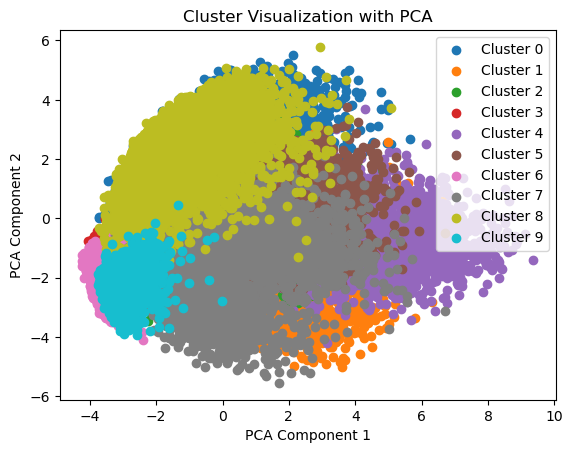

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Scatter plot
for cluster in range(n_clusters):
    plt.scatter(X_pca[spec_clusters == cluster, 0], X_pca[spec_clusters == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA')
plt.legend()
plt.show()


The plot of the first two principal components by cluster supports the conclusions drawn from the visual analysis. The larger clusters show that some clusters are absorbing digits that are not well separated. We can also see that there is some overlap and many edge cases between the clusters.

This is however, just a projection as the actual clustering is done in 100 dimensional space. For this reason, we believe that the visual inspection is a better metric of separation.

## Modeling and Evaluation 4

Summarize the Ramifications

Our highly effective model's implications are best understood from multiple angles. From a model evaluation standpoint, our primary goal of creating an accurate clustering model for grouping handwritten digits has been accomplished. The model efficiently employs pattern recognition and dimensionality reduction techniques, such as k-means for pattern recognition and PCA for dimensionality reduction. This combination allows for the effective categorization and grouping of similar handwritten digits, contributing to its success. This unsupervised technique does well at grouping most digits, greatly simplifying the process of labelling large amounts of handwritten digits.

In practical applications, this model serves as a valuable first step for accurate handwritten digit prediction. Clustering can be used to do initial sorting of images before the are labeled by a human. In this way it can be used to speed the process of creating classification models. Yet, there may exist certain limitations or considerations that warrant further exploration. Factors like deployment efficiency, scalability, and integration with other systems need careful evaluation. Additionally, assessing the model's performance on unseen data or diverse variations of handwritten digits is crucial for gauging its real-world usability.

Furthermore, the success of our robust clustering model for digit prediction might extend beyond its immediate application. The principles and features developed could potentially find relevance in related tasks. For example, the methodologies employed in handwritten digit clustering might offer adaptable components useful in domains like food categorization or image segmentation. The advancements achieved in this model's development hold the promise of contributing innovative insights to the broader fields of machine learning and computer vision. These insights could potentially enhance clustering techniques and methodologies across various tasks, not limited to handwritten digit prediction.

## Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties.

The Spectral Clustering and KMeans clustering model demonstrated strong overall performance, with Spectral Clustering achieving an adjusted RAND score of 0.62 and accuracies of over 90% for most classes. As stated above, although we are evaluating the clustering algorithms for a use case where labels aren't available, it makes sense to use the labels from the MNIST dataset to compare how the methods have performed. This would be the primary metric of concern to someone using these algorithms to generate labels as a preprocessing step for supervised learning, so we will focus on the Adjusted RAND Index. Spectral clustering acheieved a higher adjusted RAND score which makes sense, since the digits are image data and are not likely to be represented well by spherical clusters. Notably, KMeans clustering excelled in accurately clustering '1's, '2's, '6's, and '0's. However, challenges arose in distinguishing specific pairs of digits, particularly '3' and '8', '4' and '9', and '7' and '9'. The model struggled notably with '8', achieving an individual accuracy of about 50%. Additionally, the insufficient representation of '5's and '9's resulted in these digits being dispersed among other clusters, impacting the model's ability to create distinct clusters for these classes.

Did you achieve your goals?

We successfully met our objective of developing a high-performing clustering model for grouping handwritten digits. Although there's room for improvement in accurately predicting '8's, '5's, and '9's, the overall performance of the model is commendable. With some tuning, we anticipate further enhancements in these specific digit classifications.

If not, can you reign in the utility of your modeling?

How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?

Handwritten digit recognition holds immense potential for various industries like finance and logistics. The application of this model in finance, particularly in handwritten accounting tasks, could streamline processes and reduce manual effort. For logistics companies like Amazon and UPS, automating the reading of handwritten labels could significantly enhance sorting accuracy and efficiency, ensuring packages reach their destinations promptly and accurately. This automation not only saves time but also reduces errors, leading to cost savings and improved customer satisfaction by ensuring correct deliveries. While conventional supervised learning algorithms outperform clustering models at this task, we believe that clustering could greatly aid in labelling handwritten characters where labels don't exist. This would allow interested parties to quickly generate labels with less human oversight before implementing a model like a Neural Network for something like non-english handwriting where extensive datasets might not exits. Overall, the model's implementation could revolutionize operational efficiency and accuracy in these sectors.

How would your deploy your model for interested parties?

To deploy our model for interested parties, we would follow a structured deployment process:
Integration: Seamlessly integrate the model into the interested party's systems or develop an API for compatibility, potentially collaborating with their tech teams.
Customization: Tailor the model to align with the interested party's specific needs, potentially involving retraining or fine-tuning based on their handwriting styles or digit variations.
Testing and Validation: Conduct rigorous testing within the interested party's environment to ensure accurate performance. Validate the model against their datasets to confirm its effectiveness.
Documentation and Support: Provide comprehensive documentation detailing the model's usage, API instructions, and troubleshooting guides. Offer ongoing support to address any post-deployment issues.
Training and Knowledge Transfer: Conduct training sessions to familiarize the interested party's staff with effective model utilization, including understanding outputs and integrating them into workflows.
Monitoring and Updates: Establish a robust monitoring system post-deployment to continuously evaluate the model's performance. Regularly update the model to adapt to evolving handwriting styles or enhance accuracy based on feedback and new data."

What other data should be collected? How often would the model need to be updated, etc.?

Additional beneficial data includes diverse writing samples to expand the range of handwriting styles and variations. Gathering specific cases, especially for evaluating challenging classes like '8's and '9's, and considering document types (e.g., forms, checks) that might influence writing styles, could enhance model performance.
Model updates should be conducted as needed. Implementing a feedback loop for the model to learn from mistakes would be advantageous for maintaining accuracy. Post-update performance monitoring is crucial to gauge the positive impact and determine the necessity of subsequent updates.


## Exceptional Work

For the exceptional work we wanted to dive more into the realm of deep learning with neural networks. In today's age they are used heavily in NLP projects, Computer Vision, and handle large amounts of data extremly well. 

In the MNIST dataset artifical neural networks have been used to classify its text images. So we decided to create our own. For our first model we wanted to stick to using sklearn which does include some deep learning model functions that we can use. 

Multi layer Percepton or MLPClassifer is a classification algorithm that has a underlying neural network it uses. A feed forward neural network that has a input, output, and hidden layer. MLP needs to have structured data in order to perform well. As well as since the images are not complex in their writing the MLP can handle it with ease. The SGD or Stochastic Gradient decent layer is a good solver to pair with this classifier since it helps reduce time and memory usage of the data. 

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

mlp = MLPClassifier(random_state=1,
                    max_iter=100, 
                    hidden_layer_sizes=(50,), 
                    solver = 'sgd', 
                    verbose = 20, 
                    learning_rate_init = 0.1).fit(X_train, y_train)

Iteration 1, loss = 0.38416116
Iteration 2, loss = 0.18305001
Iteration 3, loss = 0.13757946
Iteration 4, loss = 0.10952309
Iteration 5, loss = 0.09313503
Iteration 6, loss = 0.07978093
Iteration 7, loss = 0.06922639
Iteration 8, loss = 0.05998485
Iteration 9, loss = 0.05261055
Iteration 10, loss = 0.04709549
Iteration 11, loss = 0.04144420
Iteration 12, loss = 0.03588441
Iteration 13, loss = 0.03345512
Iteration 14, loss = 0.02929481
Iteration 15, loss = 0.02663248
Iteration 16, loss = 0.02383690
Iteration 17, loss = 0.02167979
Iteration 18, loss = 0.01896036
Iteration 19, loss = 0.01643356
Iteration 20, loss = 0.01438411
Iteration 21, loss = 0.01358283
Iteration 22, loss = 0.01134884
Iteration 23, loss = 0.00984595
Iteration 24, loss = 0.00921494
Iteration 25, loss = 0.00758278
Iteration 26, loss = 0.00665886
Iteration 27, loss = 0.00561523
Iteration 28, loss = 0.00477617
Iteration 29, loss = 0.00445361
Iteration 30, loss = 0.00405220
Iteration 31, loss = 0.00351157
Iteration 32, los

Text(0.5, 1.0, 'Loss Curve')

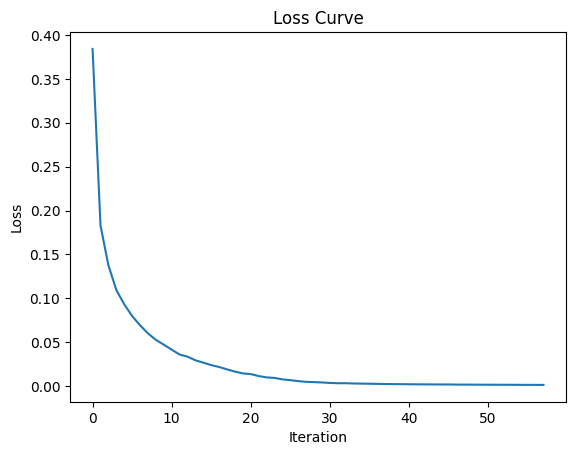

In [14]:
loss = mlp.loss_curve_
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')

From the Loss curve the MLP trained well on the data and did not blow up .

Accuracy:0.9702


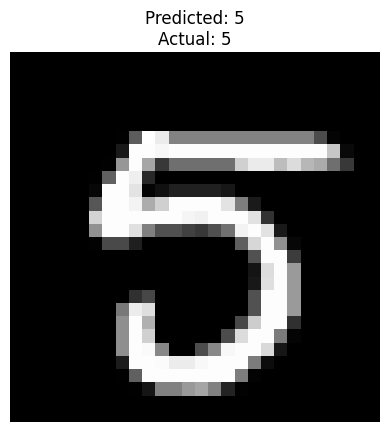

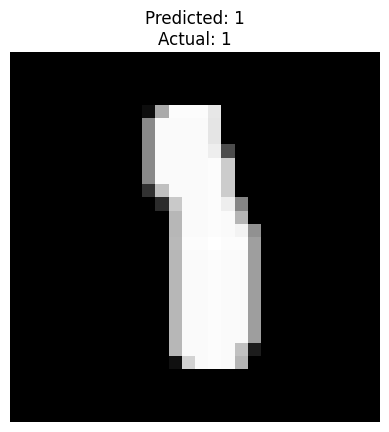

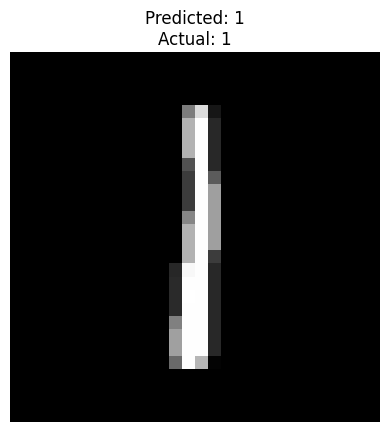

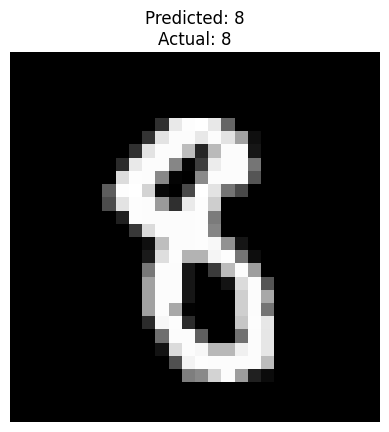

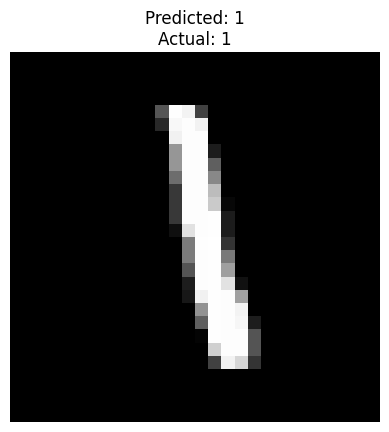

In [15]:
from sklearn.metrics import accuracy_score 

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy:.4f}")

n_samples = 5
samples = np.random.randint(0, len(X_test), n_samples)

for idx in samples:
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred[idx]}\nActual: {y_test[idx]}") 
    plt.axis('off')
    plt.show()

As we can see from the test case above the MLP model performed exceptionally well and was able to predict the text correctly a majority of the time. This model outperformed the previous models conducted. 

Diving into our next model and sticking with the theme of neural networks, one of the most popular Convolutional Neural Network. They perform exceptionally well in image classification task and can use patterns like edges and the textures of the images to classify and distingusih between digits in the mnist dataset. For this model after multiple runs and tweaks to the model the final model features  3 convolutional and max pooling layers, 1 flatten layer to convert 2d to a 1d tensor, and softmax output for its multiclassification. 

To get the model to run the data needed to change to its 28x28 image and specificed as a greyscale image. As well as using the cross entropy for the loss to have integer coded class labels. Once the model was run the loss was visualized with train and validation set to see how the model performed. 

Overall it was able to train on the data with some slight getting stuck before readjusting on the 2nd epoch. 





Epoch 1/5


1064/1064 [==============================] - 7s 6ms/step - loss: 0.3534 - accuracy: 0.8917 - val_loss: 0.3435 - val_accuracy: 0.9262
Epoch 2/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.1905 - accuracy: 0.9503 - val_loss: 0.1797 - val_accuracy: 0.9489
Epoch 3/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.1780 - accuracy: 0.9550 - val_loss: 0.2058 - val_accuracy: 0.9511
Epoch 4/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.1562 - accuracy: 0.9617 - val_loss: 0.1606 - val_accuracy: 0.9611
Epoch 5/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.1754 - accuracy: 0.9580 - val_loss: 0.2215 - val_accuracy: 0.9455


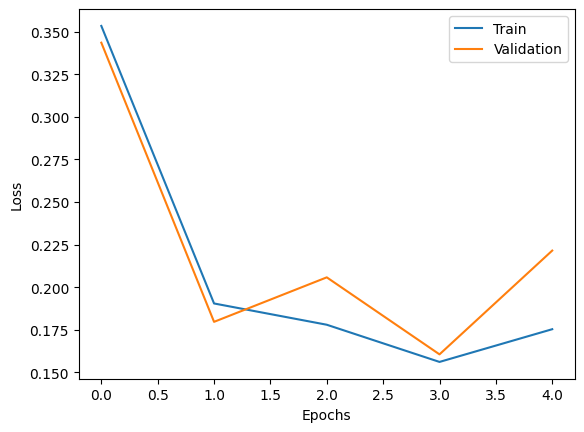

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
#reshaping of the train and test sets
# Reshape the data for CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)


#creation of the lstm 
model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), 
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(), 
    Dense(256, activation='relu'),
    Dense(64, activation = "relu"),
    Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#training the model
fitting = model.fit(X_train, y_train, epochs = 5, validation_split = 0.1)
plt.figure()
plt.plot(fitting.history['loss'], label="Train")
plt.plot(fitting.history['val_loss'], label ="Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


132/132 [==============================] - 0s 2ms/step
Test Accuracy: 0.9461904764175415


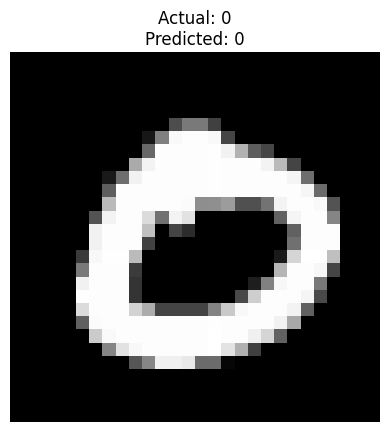

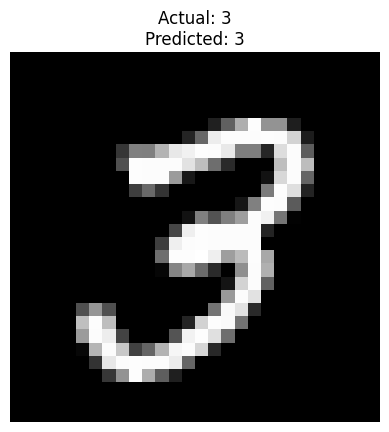

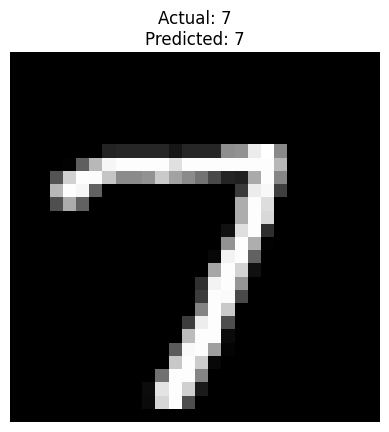

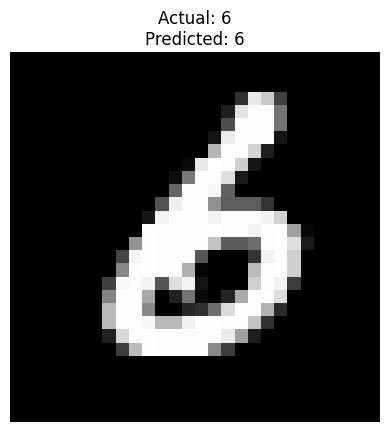

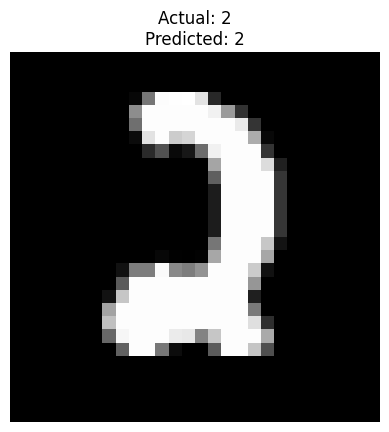

In [17]:
from sklearn.metrics import accuracy_score 
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis =1)
print(f'Test Accuracy: {test_acc}')


n_samples = 5
samples = np.random.randint(0, len(X_test), n_samples)

for idx in samples:
    # Display the original image
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Actual: {y_test[idx]}\nPredicted: {y_pred_label[idx]}")
    plt.axis('off')
    plt.show()


On the test case it was found to be 94%  accurate, which outperformed previous models tested except the mlpclassifer. Overall the neural networks worked exceptionally well for the text classification of the mnist dataset, proving their strength in Computer Vision and text classification. 


## References

@misc{digit-recognizer,
    author = {AstroDave, Will Cukierski},
    title = {Digit Recognizer},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/digit-recognizer}
}

@misc{MNIST,
    author = {Yann, LecCun, Corinna Cortes, Christopher J.C. Burges},
    title = {The MNIST Database of Handwritten Digits},
    publisher = {yan.lecun.com},
    url = {http://yann.lecun.com/exdb/mnist/}
}